# Imports

In [145]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.size': 14,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

# Diabetes

Regression, 442 objects, 10 features 

In [47]:
dataset = load_diabetes()

In [48]:
X = dataset.data
y = dataset.target

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Linear regression

In [63]:
model = LinearRegression()

In [128]:
def BootstrapLoss(m, model, exp=True, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    Parameters
    ----------
    m: int
        Available sample size
    model: sklearn / other model with *.fit() and *.predict() methods
        Model to solve a problem
    exp: bool
        Whether or not to exponentiate the loss, i.e. exp(-loss)
        
    Returns
    -------
    output: float
        Loss function on test sanmple or it after exponentiation, i.e. exp(-loss)
    """

    X_bs, y_bs = resample(X_train, y_train, replace=True, n_samples=m)
    model.fit(X_bs, y_bs)
    y_pred = model.predict(X_test)
    loss = mean_squared_error(y_test, y_pred)
    output = np.exp(-loss) if exp == True else loss
    
    return output

In [141]:
def MeanStdLoss(m, model, N=100, exp=True, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    Parameters
    ----------
    m: int
        Available sample size
    model: sklearn / other model with *.fit() and *.predict() methods
        Model to solve a problem
    N: int
        Number of samples for bootstrap
    exp: bool
        Whether or not to exponentiate the loss, i.e. exp(-loss)
    verbose: bool
        Whether or not to print progress bar (tqdm)
    
    Returns
    -------
    mean: float
        Mean value of loss for all samples
    std: float
        Standard deviation of loss for all samples
    """

    losses = np.array([BootstrapLoss(m, model, exp, X_train, X_test, y_train, y_test) for _ in range(N)])
    mean = np.mean(losses)
    std = np.std(losses)

    return mean, std

In [139]:
sample_sizes = np.arange(X_train.shape[0]) + 1

In [140]:
means = np.array([MeanStdLoss(m, model, exp=False) for m in sample_sizes])[:, 0]
stds = np.array([MeanStdLoss(m, model, exp=False) for m in sample_sizes])[:, 1]

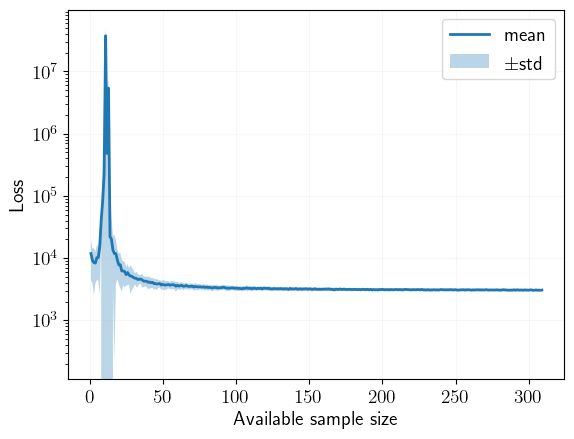

In [144]:
plt.plot(sample_sizes, means, label='mean')
plt.fill_between(sample_sizes, means - stds, means + stds, alpha=0.3, label=r'$\pm$std')
plt.xlabel('Available sample size')
#plt.xscale()
plt.ylabel('Loss')
#plt.yscale('log')
plt.legend()
plt.show()

# Linear Regression + L2 regularization

In [146]:
model = Ridge()

In [147]:
sample_sizes = np.arange(X_train.shape[0]) + 1
means = np.array([MeanStdLoss(m, model, exp=False) for m in sample_sizes])[:, 0]
stds = np.array([MeanStdLoss(m, model, exp=False) for m in sample_sizes])[:, 1]

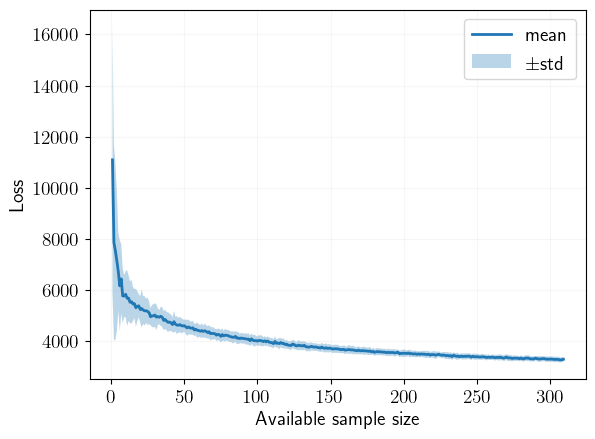

In [148]:
plt.plot(sample_sizes, means, label='mean')
plt.fill_between(sample_sizes, means - stds, means + stds, alpha=0.3, label=r'$\pm$std')
plt.xlabel('Available sample size')
#plt.xscale()
plt.ylabel('Loss')
#plt.yscale('log')
plt.legend()
plt.show()

# Linear Regression + L1 regularization

In [149]:
model = Lasso()

In [150]:
sample_sizes = np.arange(X_train.shape[0]) + 1
means = np.array([MeanStdLoss(m, model, exp=False) for m in sample_sizes])[:, 0]
stds = np.array([MeanStdLoss(m, model, exp=False) for m in sample_sizes])[:, 1]

c:\Users\kisnikser\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\kisnikser\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\kisnikser\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+

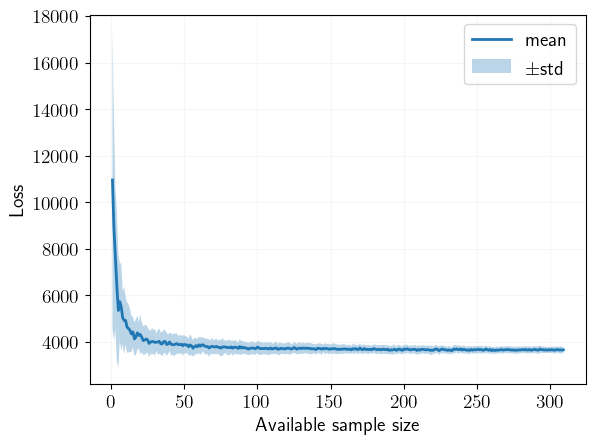

In [151]:
plt.plot(sample_sizes, means, label='mean')
plt.fill_between(sample_sizes, means - stds, means + stds, alpha=0.3, label=r'$\pm$std')
plt.xlabel('Available sample size')
#plt.xscale()
plt.ylabel('Loss')
#plt.yscale('log')
plt.legend()
plt.show()

# Linear Regression + L1 and L2 regularization

In [152]:
model = ElasticNet()

In [153]:
sample_sizes = np.arange(X_train.shape[0]) + 1
means = np.array([MeanStdLoss(m, model, exp=False) for m in sample_sizes])[:, 0]
stds = np.array([MeanStdLoss(m, model, exp=False) for m in sample_sizes])[:, 1]

c:\Users\kisnikser\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\kisnikser\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\kisnikser\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+

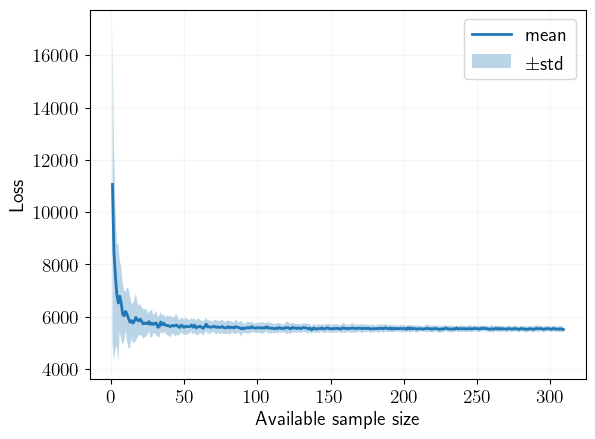

In [154]:
plt.plot(sample_sizes, means, label='mean')
plt.fill_between(sample_sizes, means - stds, means + stds, alpha=0.3, label=r'$\pm$std')
plt.xlabel('Available sample size')
#plt.xscale()
plt.ylabel('Loss')
#plt.yscale('log')
plt.legend()
plt.show()